In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.sql.functions import *
from pyspark.sql.types import DateType
from pyspark.sql.window import Window
import pyspark.sql.functions as F

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [4]:
df_fuel = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("/user/fuel.csv")
df_counties = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("/user/us-counties.csv")

In [5]:
df_counties.show(10)

+-------------------+-----------+----------+----------------+---------------+------+
|               date|     county|state_name|county_fips_code|confirmed_cases|deaths|
+-------------------+-----------+----------+----------------+---------------+------+
|2020-08-02 00:00:00|     Joplin|  Missouri|            null|            448|    20|
|2020-08-02 00:00:00|Kansas City|  Missouri|            null|           5929|    69|
|2020-08-03 00:00:00|     Joplin|  Missouri|            null|            453|    21|
|2020-08-03 00:00:00|Kansas City|  Missouri|            null|           6027|    69|
|2020-08-04 00:00:00|     Joplin|  Missouri|            null|            467|    21|
|2020-08-04 00:00:00|Kansas City|  Missouri|            null|           6137|    69|
|2020-08-05 00:00:00|     Joplin|  Missouri|            null|            477|    21|
|2020-08-05 00:00:00|Kansas City|  Missouri|            null|           6268|    69|
|2020-08-06 00:00:00|     Joplin|  Missouri|            null|    

In [7]:
df_counties = df_counties.select(col('date').cast(DateType()).alias('date'), 'county', 'state_name', 'confirmed_cases', 'deaths')

In [9]:
df_us = df_counties.groupBy('date').agg(F.sum('confirmed_cases').alias('confirmed_cases'), F.sum('deaths').alias('deaths'))

In [11]:
window = Window.partitionBy().orderBy('date')
df_us_cl = df_us.withColumn('confirmed_last', lag('confirmed_cases', 1).over(window))
df_us_nc = df_us_cl.withColumn('new_confirmed', df_us_cl['confirmed_cases'] - df_us_cl['confirmed_last'])
df_us_nc.show(100)

+----------+---------------+------+--------------+-------------+
|      date|confirmed_cases|deaths|confirmed_last|new_confirmed|
+----------+---------------+------+--------------+-------------+
|2020-01-21|              1|     0|          null|         null|
|2020-01-22|              1|     0|             1|            0|
|2020-01-23|              1|     0|             1|            0|
|2020-01-24|              2|     0|             1|            1|
|2020-01-25|              3|     0|             2|            1|
|2020-01-26|              5|     0|             3|            2|
|2020-01-27|              5|     0|             5|            0|
|2020-01-28|              5|     0|             5|            0|
|2020-01-29|              5|     0|             5|            0|
|2020-01-30|              6|     0|             5|            1|
|2020-01-31|              7|     0|             6|            1|
|2020-02-01|              8|     0|             7|            1|
|2020-02-02|             

In [12]:
df_us_dl = df_us_nc.withColumn('deaths_last', lag('deaths', 1).over(window))
df_us_nd = df_us_dl.withColumn('new_deaths', df_us_dl['deaths'] - df_us_dl['deaths_last'])
df_us_nd.show(10)

+----------+---------------+------+--------------+-------------+-----------+----------+
|      date|confirmed_cases|deaths|confirmed_last|new_confirmed|deaths_last|new_deaths|
+----------+---------------+------+--------------+-------------+-----------+----------+
|2020-01-21|              1|     0|          null|         null|       null|      null|
|2020-01-22|              1|     0|             1|            0|          0|         0|
|2020-01-23|              1|     0|             1|            0|          0|         0|
|2020-01-24|              2|     0|             1|            1|          0|         0|
|2020-01-25|              3|     0|             2|            1|          0|         0|
|2020-01-26|              5|     0|             3|            2|          0|         0|
|2020-01-27|              5|     0|             5|            0|          0|         0|
|2020-01-28|              5|     0|             5|            0|          0|         0|
|2020-01-29|              5|    

In [13]:
df_us_final = df_us_nd.select('date', 'new_confirmed', 'new_deaths')
df_us_final.show(10)

+----------+-------------+----------+
|      date|new_confirmed|new_deaths|
+----------+-------------+----------+
|2020-01-21|         null|      null|
|2020-01-22|            0|         0|
|2020-01-23|            0|         0|
|2020-01-24|            1|         0|
|2020-01-25|            1|         0|
|2020-01-26|            2|         0|
|2020-01-27|            0|         0|
|2020-01-28|            0|         0|
|2020-01-29|            0|         0|
|2020-01-30|            1|         0|
+----------+-------------+----------+
only showing top 10 rows



In [14]:
df_fuel.show(10)

+-------------------+-------------+------------------------+-------+
|               date|vehicle_class|percent_of_normal_volume|version|
+-------------------+-------------+------------------------+-------+
|2020-11-24 00:00:00|          MPV|                  120.33|    1.0|
|2020-11-24 00:00:00|          MDT|      130.57000000000002|    1.0|
|2020-11-24 00:00:00|          Bus|                   66.77|    1.0|
|2020-11-24 00:00:00|    Passenger|                   84.66|    1.0|
|2020-11-24 00:00:00|          LDT|                  159.35|    1.0|
|2020-11-24 00:00:00|          HDT|                  117.63|    1.0|
|2020-07-10 00:00:00|          HDT|      105.60000000000001|    1.0|
|2020-07-10 00:00:00|          Bus|                   22.93|    1.0|
|2020-07-10 00:00:00|          MPV|                  106.62|    1.0|
|2020-07-10 00:00:00|          LDT|                  153.83|    1.0|
+-------------------+-------------+------------------------+-------+
only showing top 10 rows



In [15]:
df_fuel.groupBy('vehicle_class').count().show()

+-------------+-----+
|vehicle_class|count|
+-------------+-----+
|          MPV|  260|
|          HDT|  260|
|    Passenger|  260|
|          Bus|  260|
|          LDT|  260|
|          MDT|  260|
+-------------+-----+



In [16]:
df_fuel = df_fuel.select(col('date').cast(DateType()).alias('date'), 'vehicle_class', 'percent_of_normal_volume')
df_fuel.show(10)

+----------+-------------+------------------------+
|      date|vehicle_class|percent_of_normal_volume|
+----------+-------------+------------------------+
|2020-11-24|          MPV|                  120.33|
|2020-11-24|          MDT|      130.57000000000002|
|2020-11-24|          Bus|                   66.77|
|2020-11-24|    Passenger|                   84.66|
|2020-11-24|          LDT|                  159.35|
|2020-11-24|          HDT|                  117.63|
|2020-07-10|          HDT|      105.60000000000001|
|2020-07-10|          Bus|                   22.93|
|2020-07-10|          MPV|                  106.62|
|2020-07-10|          LDT|                  153.83|
+----------+-------------+------------------------+
only showing top 10 rows



In [17]:
df_us_final.count()

312

In [18]:
df_fuel.count()

1560

In [19]:
df_fuel_joined = df_fuel.join(df_us_final, ['date'])
df_fuel_joined.show(10)

+----------+-------------+------------------------+-------------+----------+
|      date|vehicle_class|percent_of_normal_volume|new_confirmed|new_deaths|
+----------+-------------+------------------------+-------------+----------+
|2020-03-13|          Bus|                    97.6|          556|         7|
|2020-03-13|          LDT|      105.52999999999999|          556|         7|
|2020-03-13|          HDT|      107.41000000000001|          556|         7|
|2020-03-13|          MDT|                  106.15|          556|         7|
|2020-03-13|          MPV|                  102.71|          556|         7|
|2020-03-13|    Passenger|      102.28999999999999|          556|         7|
|2020-03-14|    Passenger|                   100.1|          674|        10|
|2020-03-14|          HDT|      104.67999999999999|          674|        10|
|2020-03-14|          Bus|                   74.67|          674|        10|
|2020-03-14|          LDT|                   100.8|          674|        10|

In [20]:
df_fuel_joined.count()

1560

In [24]:
df_mpv = df_fuel_joined.filter(col('vehicle_class') == 'MPV').toPandas()
df_hdt = df_fuel_joined.filter(col('vehicle_class') == 'HDT').toPandas()
df_passenger = df_fuel_joined.filter(col('vehicle_class') == 'Passenger').toPandas()
df_bus = df_fuel_joined.filter(col('vehicle_class') == 'Bus').toPandas()
df_ldt = df_fuel_joined.filter(col('vehicle_class') == 'LDT').toPandas()
df_mdt = df_fuel_joined.filter(col('vehicle_class') == 'MDT').toPandas()

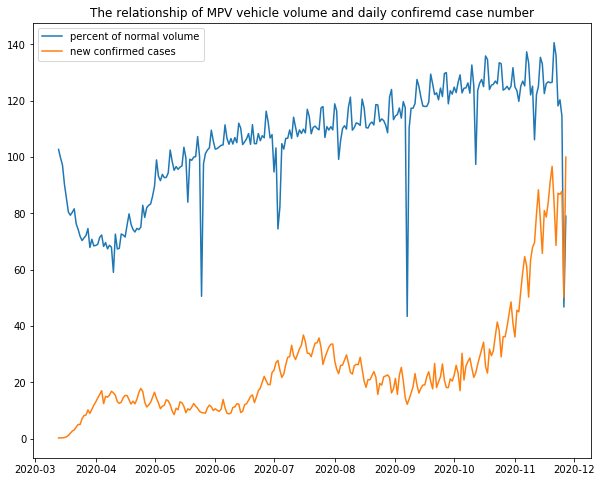

In [25]:
df = df_mpv
plt.plot(df['date'], df['percent_of_normal_volume'], label='percent of normal volume')
plt.plot(df['date'], 100*df['new_confirmed']/df['new_confirmed'].max(), label='new confirmed cases')
plt.legend()
plt.title('The relationship of {} vehicle volume and daily confiremd case number'.format(df['vehicle_class'][0]))
plt.show()

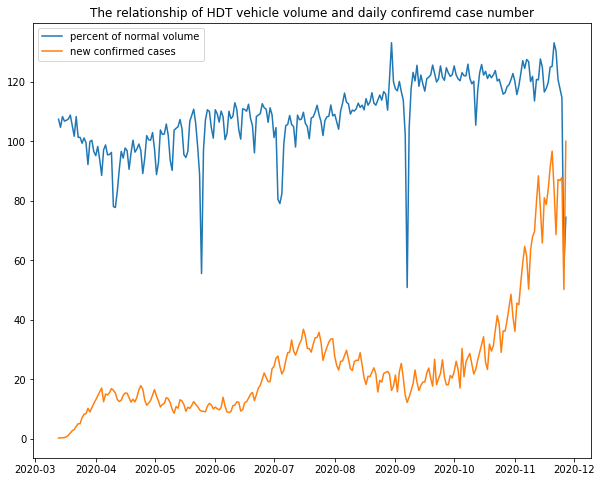

In [26]:
df = df_hdt
plt.plot(df['date'], df['percent_of_normal_volume'], label='percent of normal volume')
plt.plot(df['date'], 100*df['new_confirmed']/df['new_confirmed'].max(), label='new confirmed cases')
plt.legend()
plt.title('The relationship of {} vehicle volume and daily confiremd case number'.format(df['vehicle_class'][0]))
plt.show()

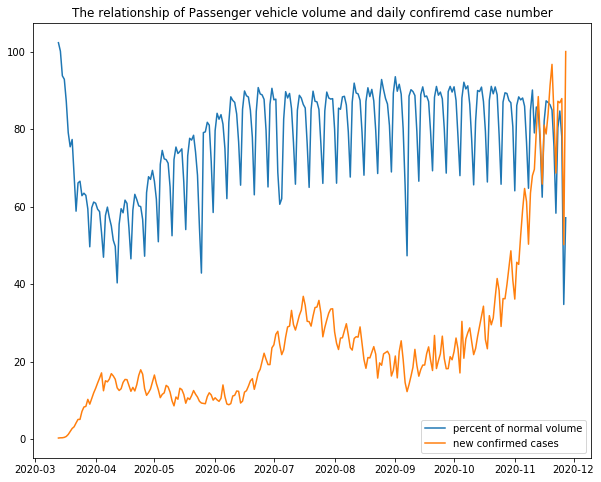

In [27]:
df = df_passenger
plt.plot(df['date'], df['percent_of_normal_volume'], label='percent of normal volume')
plt.plot(df['date'], 100*df['new_confirmed']/df['new_confirmed'].max(), label='new confirmed cases')
plt.legend()
plt.title('The relationship of {} vehicle volume and daily confiremd case number'.format(df['vehicle_class'][0]))
plt.show()

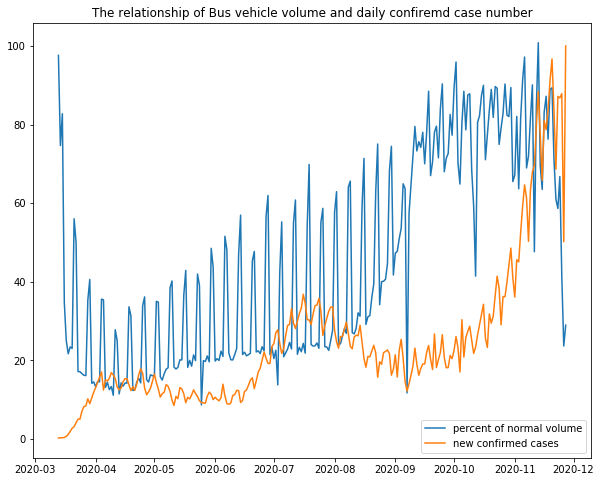

In [28]:
df = df_bus
plt.plot(df['date'], df['percent_of_normal_volume'], label='percent of normal volume')
plt.plot(df['date'], 100*df['new_confirmed']/df['new_confirmed'].max(), label='new confirmed cases')
plt.legend()
plt.title('The relationship of {} vehicle volume and daily confiremd case number'.format(df['vehicle_class'][0]))
plt.show()

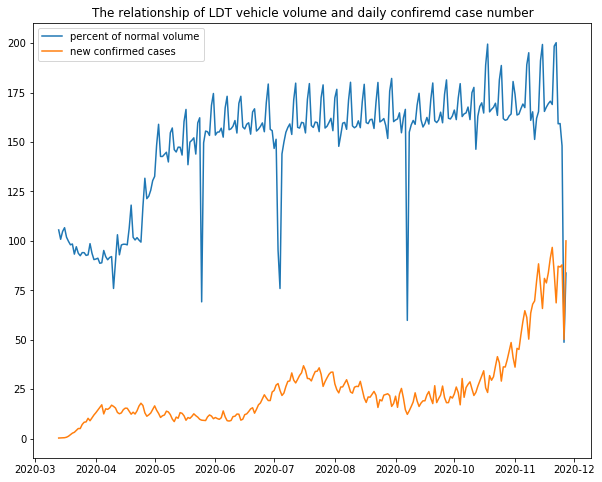

In [29]:
df = df_ldt
plt.plot(df['date'], df['percent_of_normal_volume'], label='percent of normal volume')
plt.plot(df['date'], 100*df['new_confirmed']/df['new_confirmed'].max(), label='new confirmed cases')
plt.legend()
plt.title('The relationship of {} vehicle volume and daily confiremd case number'.format(df['vehicle_class'][0]))
plt.show()

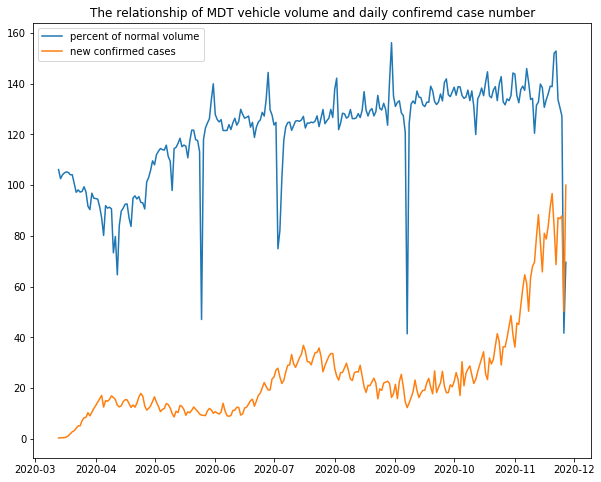

In [30]:
df = df_mdt
plt.plot(df['date'], df['percent_of_normal_volume'], label='percent of normal volume')
plt.plot(df['date'], 100*df['new_confirmed']/df['new_confirmed'].max(), label='new confirmed cases')
plt.legend()
plt.title('The relationship of {} vehicle volume and daily confiremd case number'.format(df['vehicle_class'][0]))
plt.show()

In [31]:
df_fuel_avg = df_fuel.groupBy('date').agg(F.avg('percent_of_normal_volume').alias('percent_of_normal_volume'))
df_fuel_avg.show(10)

+----------+------------------------+
|      date|percent_of_normal_volume|
+----------+------------------------+
|2020-08-24|      106.79166666666667|
|2020-07-24|      100.85166666666667|
|2020-08-05|      104.20666666666666|
|2020-04-30|       85.75666666666667|
|2020-08-29|      118.10833333333333|
|2020-08-28|      104.26666666666667|
|2020-10-04|      116.76666666666667|
|2020-03-13|      103.61500000000001|
|2020-09-24|      120.72500000000002|
|2020-05-23|       98.81999999999998|
+----------+------------------------+
only showing top 10 rows



In [32]:
df_fuel_avg_joined = df_fuel_avg.join(df_us_final, ['date'])
df_fuel_avg_joined.show(10)

+----------+------------------------+-------------+----------+
|      date|percent_of_normal_volume|new_confirmed|new_deaths|
+----------+------------------------+-------------+----------+
|2020-03-13|      103.61500000000001|          556|         7|
|2020-03-14|       97.08833333333332|          674|        10|
|2020-03-15|       98.46500000000002|          702|         8|
|2020-03-16|       89.38000000000001|          907|        23|
|2020-03-17|       85.27500000000002|         1399|        26|
|2020-03-18|                   82.26|         2444|        45|
|2020-03-19|       81.52166666666666|         4043|        50|
|2020-03-20|                  81.425|         5619|        65|
|2020-03-21|                  83.585|         6516|        83|
|2020-03-22|       81.27499999999999|         8545|        98|
+----------+------------------------+-------------+----------+
only showing top 10 rows



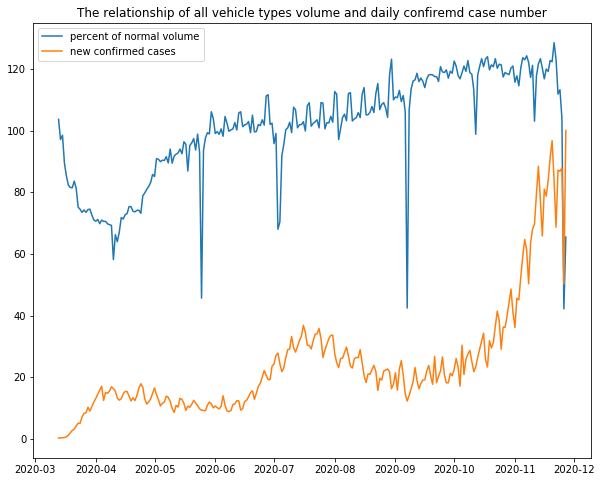

In [33]:
df_all = df_fuel_avg_joined.toPandas()
plt.plot(df_all['date'], df_all['percent_of_normal_volume'], label='percent of normal volume')
plt.plot(df['date'], 100*df_all['new_confirmed']/df_all['new_confirmed'].max(), label='new confirmed cases')
plt.legend()
plt.title('The relationship of all vehicle types volume and daily confiremd case number')
plt.show()